In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def l0_penalty(beta, tol=0.0):
    return np.where(np.abs(beta) > tol, 1.0, 0.0)

def l1_penalty(beta):
    return np.abs(beta)

def l2_penalty(beta):
    return beta**2

def scad_penalty(beta, lam=3.0, a=3.7):
    abs_b = np.abs(beta)
    penalty = np.piecewise(abs_b,
        [abs_b <= lam,
         (abs_b > lam) & (abs_b <= a * lam),
         abs_b > a * lam],
        [lambda x: lam * x,
        lambda x: (-x**2 + 2*a*lam*x - lam**2) / (2*(a - 1)),
        lambda x: (lam**2 * (a + 1)) / 2])
    return penalty

def mcp_penalty(beta, lam=3.0, gamma=3.0):
    abs_b = np.abs(beta)
    penalty = np.where(abs_b <= gamma * lam,
                       lam * abs_b - (abs_b**2) / (2 * gamma),
                       0.5 * gamma * lam**2)
    return penalty

def rho_nu(beta, nu):
    abs_b = np.abs(beta)
    return abs_b / (1 + abs_b**(1 - nu))

In [ ]:
# Domaine de beta
beta = np.linspace(-3, 3, 401)

a = 3.7
gamma = 3.0
lam = 1.0

l0 = l0_penalty(beta)
l1 = l1_penalty(beta)
l2 = l2_penalty(beta)
scad = scad_penalty(beta, lam, a)
mcp = mcp_penalty(beta, lam, gamma)
nus = [0.1, 0.5, 0.9, 0.99]
pen_nus = [rho_nu(beta, nu) for nu in nus]

# Plot 1: L0, L1, L2
plt.figure(figsize=(6, 5))
plt.plot(beta, l0, label=r'$\ell_0$', linestyle='--')
plt.plot(beta, l1, label=r'$\ell_1$', linestyle='-')
plt.plot(beta, l2, label=r'$\ell_2$', linestyle='-.')
plt.title("Comparaison des pénalités standards", fontsize=14)
plt.xlabel(r'$\beta$', fontsize=12)
plt.ylabel(r'Pénalité', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("G:\Mon Drive\Projets\Stage Genève\Rapport\images\graphs\penalty_l0_l1_l2.pdf")

# Plot 2: SCAD, MCP, L1, L0
plt.figure(figsize=(6, 5))
plt.plot(beta, scad, label=rf'SCAD ($\lambda={lam},\ a={a}$)', linestyle='-')
plt.plot(beta, mcp, label=rf'MCP ($\lambda={lam},\ \gamma={gamma}$)', linestyle='--')
plt.plot(beta, l1, label=r'$\ell_1$', linestyle='-.')
plt.plot(beta, l0, label=r'$\ell_0$', linestyle=':')
plt.title("Comparaison des pénalités non convexes", fontsize=14)
plt.xlabel(r'$\beta$', fontsize=12)
plt.ylabel(r'Pénalité', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("G:\Mon Drive\Projets\Stage Genève\Rapport\images\graphs\penalty_scad_mcp.pdf")

# Plot 3: Rho_nu, L1, L0
plt.figure(figsize=(6, 5))
for i, nu in enumerate(nus):
    plt.plot(beta, pen_nus[i], label=rf'$P_{{\nu}}$ ($\nu={nu}$)', linestyle='-')
plt.plot(beta, l1, label=r'$\ell_1$', linestyle='-.')
plt.plot(beta, l0, label=r'$\ell_0$', linestyle=':')

plt.title("Comparaison de la pénalité $P_\\nu$ avec $\ell_0$ et $\ell_1$", fontsize=14)
plt.xlabel(r'$\beta$', fontsize=12)
plt.ylabel(r'Pénalité', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("G:\Mon Drive\Projets\Stage Genève\Rapport\images\graphs\penalty_p_nu.pdf")

In [6]:
def soft_threshold(z, gamma):
    return np.sign(z) * np.maximum(np.abs(z) - gamma, 0.0)

def hard_threshold(z, gamma):
    return z * (np.abs(z) > gamma)

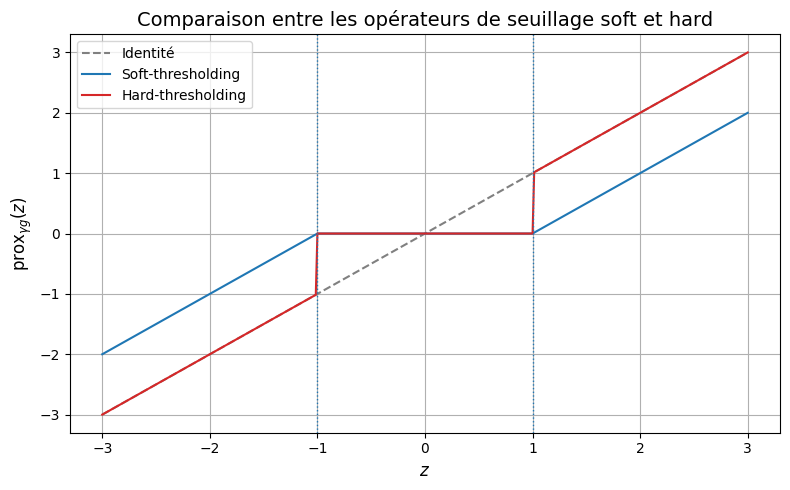

In [8]:
# Paramètres
z = np.linspace(-3, 3, 400)
gamma = 1.0  # seuil choisi
tau_hard = gamma

# Calcul des valeurs
soft = soft_threshold(z, gamma)
hard = hard_threshold(z, tau_hard)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(z, z, label="Identité", linestyle='--', color='gray')
plt.plot(z, soft, label=rf'Soft-thresholding', linestyle='-', color='tab:blue')
plt.plot(z, hard, label=rf'Hard-thresholding', linestyle='-', color='tab:red')

# Marquer les seuils
plt.axvline(x=gamma, color='tab:blue', linestyle=':', linewidth=1)
plt.axvline(x=-gamma, color='tab:blue', linestyle=':', linewidth=1)

plt.title("Comparaison entre les opérateurs de seuillage soft et hard", fontsize=14)
plt.xlabel(r'$z$', fontsize=12)
plt.ylabel(r'$\mathrm{prox}_{\gamma g}(z)$', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("G:\Mon Drive\Projets\Stage Genève\Rapport\images\graphs\prox_soft_vs_hard.pdf")

In [ ]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent)+"\AYMEN\EXPLORATION\CAS LINEAIRE\OUTILS")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from linear_tools import dichotomie, newton

# ---- Fonctions utiles ----
def rho_nu_prime(beta, nu):
    abs_beta = np.abs(beta)
    denom = (1 + abs_beta**(1 - nu))**2
    return np.sign(beta) * (1 + nu * abs_beta**(1 - nu)) / denom

def drho_nu_prime(beta, nu):
    abs_beta = np.abs(beta)
    num = nu * (1 - nu) * abs_beta**(-nu)
    denom = (1 + abs_beta**(1 - nu))**3
    return num / denom

def get_jump(lmbda, nu, tol=1e-8):
    def F(k, lmbda, nu):
        return k**(2 - nu) + 2*k + k**nu + 2 * lmbda * (nu - 1)
    return dichotomie(F, [lmbda, nu], 1e-12, 500, tol)

def prox_p_nu(z, lmbda, nu, tol=1e-8):
    """Prox de P_nu pour un vecteur z"""
    z = np.asarray(z)
    if nu == 1.0:
        return np.sign(z) * np.maximum(np.abs(z) - lmbda, 0.0)

    kappa = get_jump(lmbda, nu, tol)
    phi = 0.5 * kappa + lmbda / (1 + kappa**(1 - nu))

    prox = np.zeros_like(z)
    mask = np.abs(z) > phi

    for i in np.where(mask)[0]:
        prox[i] = newton(
            lambda b, z_, l_, n_: b - z_ + l_ * rho_nu_prime(b, n_),
            lambda b, z_, l_, n_: 1 + l_ * drho_nu_prime(b, n_),
            F_args=(z[i], lmbda, nu),
            x0=z[i], tol=tol
        )
    return prox

def soft_threshold(z, gamma):
    return np.sign(z) * np.maximum(np.abs(z) - gamma, 0.0)

def hard_threshold(z, tau):
    return np.where(np.abs(z) > tau, z, 0.0)

# ---- Paramètres et calculs ----
z = np.linspace(-3, 3, 800)
gamma = 1.0
tau_hard = gamma

soft = soft_threshold(z, gamma)
hard = hard_threshold(z, tau_hard)

nus = [0.1, 0.5, 0.9]
prox_curves = [prox_p_nu(z, gamma, nu) for nu in nus]

# ---- Tracé ----
plt.figure(figsize=(8, 5))
plt.plot(z, z, '--', color='gray', label="Identité")
plt.plot(z, soft, label=fr"Soft", color='tab:blue')
plt.plot(z, hard, label=fr"Hard", color='tab:red')
for nu, prox_vals in zip(nus, prox_curves):
    plt.plot(z, prox_vals, label=fr"Prox $P_\nu$ ($\nu={nu}$)", color=f"C{nus.index(nu) + 7}")

# Marquer les seuils
plt.axvline(x=gamma, color='tab:blue', linestyle=':', linewidth=1)
plt.axvline(x=-gamma, color='tab:blue', linestyle=':', linewidth=1)
plt.axvline(x=tau_hard, color='tab:red', linestyle=':', linewidth=1)
plt.axvline(x=-tau_hard, color='tab:red', linestyle=':', linewidth=1)

plt.title("Soft, Hard et prox de $P_\\nu$")
plt.xlabel(r"$z$")
plt.ylabel(r"$\mathrm{prox}(z)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("G:\Mon Drive\Projets\Stage Genève\Rapport\images\graphs\prox_soft_vs_hard_vs_Pnu.pdf")
plt.show()

In [2]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent)+"\AYMEN\EXPLORATION\CAS LINEAIRE\OUTILS")

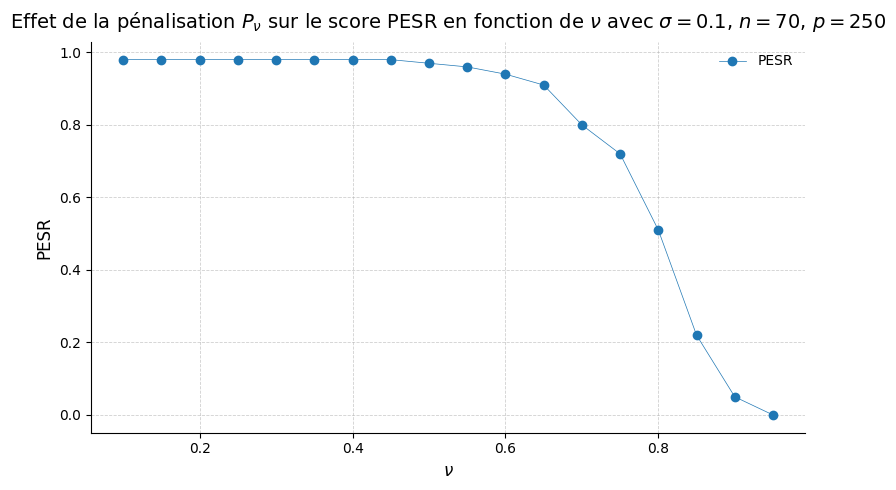

In [3]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional

from linear_tools import (
    generate_data, pesr, plot_scores, ista_backtracking,
    qut_square_root_lasso, dichotomie, newton
)


# --------------------------- Simulation ------------------------------------ #

class Simulation:
    """
    Simulation Harder LASSO (ISTA + backtracking) pour un nu donné.
    La logique, les formules et les valeurs calculées sont inchangées
    par rapport au code d'origine.
    """

    def __init__(
        self,
        n: int,
        p: int,
        list_s: List[int],
        sigma: float,
        nu: Optional[float] = None,
        simu_iter: int = 100,
        qut_iter: int = 100,
        max_iter: int = 1000,
        tol: float = 1e-6,
        seed: int = 42,
        verbose: bool = False,
    ):
        self.n = n
        self.p = p
        self.list_s = list_s
        self.sigma = sigma

        # Identique à l'original : si nu n'est pas spécifié, répéter 0.9 six fois
        self.nu_vals = [nu] if nu is not None else [0.9] * 6

        self.L0 = 10.0
        self.beta0 = 3.0

        self.simu_iter = simu_iter
        self.qut_iter = qut_iter
        self.max_iter = max_iter
        self.tol = tol
        self.seed = seed
        self.verbose = verbose

        np.random.seed(self.seed)
        np.set_printoptions(precision=3, suppress=True, linewidth=120)

        self.score: Dict[str, List[float]] = {"pesr": []}

    # ------------------------ Problème / pénalité --------------------------- #

    @staticmethod
    def _f(beta: np.ndarray, y: np.ndarray, X: np.ndarray) -> float:
        # Norme L2 du résidu (identique)
        return np.linalg.norm(y - X @ beta, ord=2)

    @staticmethod
    def _grad_f(beta: np.ndarray, y: np.ndarray, X: np.ndarray) -> np.ndarray:
        # Gradient de la norme L2 (identique)
        r = y - X @ beta
        nr = np.linalg.norm(r, ord=2)
        if nr == 0:
            return np.zeros_like(beta)
        return -X.T @ r / nr

    @staticmethod
    def _g(beta: np.ndarray, lmbda: float, nu: float) -> float:
        # Pénalité P_nu (identique)
        ab = np.abs(beta)
        return lmbda * np.sum(ab / (1 + ab ** (1 - nu)))

    @staticmethod
    def _rho_nu_prime(beta: np.ndarray, nu: float) -> np.ndarray:
        ab = np.abs(beta)
        denom = (1 + ab ** (1 - nu)) ** 2
        return np.sign(beta) * (1 + nu * ab ** (1 - nu)) / denom

    @staticmethod
    def _drho_nu_prime(beta: np.ndarray, nu: float) -> np.ndarray:
        ab = np.abs(beta)
        num = nu * (1 - nu) * ab ** (-nu)
        denom = (1 + ab ** (1 - nu)) ** 3
        return num / denom

    def _F_beta(self, beta: float, z: float, lmbda: float, nu: float) -> float:
        return beta - z + lmbda * self._rho_nu_prime(np.array([beta]), nu)[0]

    def _F_beta_prime(self, beta: float, z: float, lmbda: float, nu: float) -> float:
        return 1 + lmbda * self._drho_nu_prime(np.array([beta]), nu)[0]

    def _get_jump(self, lmbda_scaled: float, nu: float) -> float:
        # Identique : zéro de F(k) sur [1e-25, 500] via dichotomie
        def F(k, lmbda, nu_):
            return k ** (2 - nu_) + 2 * k + k ** nu_ + 2 * lmbda * (nu_ - 1)

        a, b = 1e-25, 500.0
        return dichotomie(F, [lmbda_scaled, nu], a, b, self.tol)

    def _prox_g(self, z: np.ndarray, L: float, lmbda: float, nu: float) -> np.ndarray:
        # Prox identique (soft si nu=1, sinon Newton coordonné au-dessus d'un seuil)
        lmbda_scaled = lmbda / L

        if nu == 1.0:
            return np.sign(z) * np.maximum(np.abs(z) - lmbda_scaled, 0.0)

        kappa = self._get_jump(lmbda_scaled, nu)
        phi = 0.5 * kappa + lmbda_scaled / (1 + kappa ** (1 - nu))

        prox = np.zeros_like(z)
        mask = np.abs(z) > phi
        prox[~mask] = 0.0

        # Newton coordonné comme dans le code initial
        idxs = np.where(mask)[0]
        for i in idxs:
            prox[i] = newton(
                self._F_beta,
                self._F_beta_prime,
                F_args=(z[i], lmbda_scaled, nu),
                x0=z[i],
                tol=1e-6,
            )
        return prox

    # ----------------------- Données / hyperparamètres ---------------------- #

    def _generate_data(self, s: int, seed: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        if seed is None:
            seed = self.seed
        y, X, beta = generate_data(
            n=self.n, p=self.p, s=s, sigma=self.sigma, beta0=self.beta0, seed=seed
        )
        X = X / X.std(axis=0)  # normalisation identique
        return y, X, beta

    def _get_lambda(self, X: np.ndarray, alpha: float = 0.05, seed: Optional[int] = None) -> float:
        if seed is None:
            seed = self.seed
        return qut_square_root_lasso(X=X, M=self.qut_iter, alpha=alpha, seed=seed)

    def _lambda_nu_path(self, lmbda_max: float) -> List[Tuple[float, float]]:
        # Identique : ratio sigmoïde en fonction de k
        if len(self.nu_vals) == 1:
            return [(lmbda_max, self.nu_vals[0])]
        path: List[Tuple[float, float]] = []
        for k, nu_k in enumerate(self.nu_vals):
            ratio = np.exp(k) / (1 + np.exp(k))
            lmbda_k = ratio * lmbda_max
            path.append((lmbda_k, nu_k))
        return path

    # ----------------------------- Boucles ---------------------------------- #

    def _score_once(self, beta: np.ndarray, beta_hat: np.ndarray) -> Dict[str, float]:
        return {"pesr": float(pesr(beta, beta_hat))}

    def _simulate_for_s(self, s: int) -> Dict[str, List[float]]:
        local_scores = {"pesr": []}
        if self.verbose:
            print(f"|{s}| Simulations pour s = {s} :")

        for i in range(self.simu_iter):
            y, X, beta = self._generate_data(s, seed=self.seed + i)
            lmbda = 1.0 * self._get_lambda(X)  # (identique)

            beta_hat = np.zeros(self.p)
            for lmbda_k, nu_k in self._lambda_nu_path(lmbda):
                beta_hat = ista_backtracking(
                    f=self._f,
                    g=self._g,
                    grad_f=self._grad_f,
                    prox_g=self._prox_g,
                    x0=beta_hat,
                    L0=self.L0,
                    f_args=(y, X),
                    g_args=[lmbda_k, nu_k],
                    grad_f_args=(y, X),
                    prox_g_args=[lmbda_k, nu_k],
                    max_iter=self.max_iter,
                    tol=self.tol,
                )

            sc = self._score_once(beta, beta_hat)
            local_scores["pesr"].append(sc["pesr"])

            if self.verbose:
                print(f"\t |{i+1}| Simulation {i+1}/{self.simu_iter} :")
                print(f"\t\t Lambda : {lmbda}")
                print(f"\t\t PESR : {sc['pesr']:.6f}")

        # moyenne (identique au comportement original)
        return {"pesr": [float(np.mean(local_scores["pesr"]))]}

    def run(self) -> None:
        for s in self.list_s:
            sc = self._simulate_for_s(s)
            self.score["pesr"].append(sc["pesr"])

    def quick_plot(self, title: str) -> None:
        # Conserve l'appel d'origine au helper si besoin
        plot_scores(self.score, self.list_s, title)

# --------------------------- Lancement étude nu ----------------------------- #

# Paramètres
n = 70
p = 250
list_s = [0]
list_nu = np.arange(0.1, 1.0, 0.05)
simu_iter = 100
verbose = False

sigma = 0.1
qut_iter = 1000
max_iter = 1000
tol = 1e-8
seed = 42

scores_by_nu: Dict[str, Dict[str, List[List[float]]]] = {}

for nu in list_nu:
    if verbose:
        print(f"=> Simulation avec nu = {nu:.2f}")

    sim = Simulation(
        n=n,
        p=p,
        list_s=list_s,
        sigma=sigma,
        nu=nu,
        simu_iter=simu_iter,
        qut_iter=qut_iter,
        max_iter=max_iter,
        tol=tol,
        seed=seed,
        verbose=verbose,
    )

    # Comme dans ton code
    sim.L0 = 0.1
    sim.run()
    scores_by_nu[f"nu = {nu:.2f}"] = sim.score

# Aplatir pour la courbe PESR vs nu (identique en contenu)
pesr_values = [np.mean(scores_by_nu[f"nu = {nu:.2f}"]["pesr"]) for nu in list_nu]

# --------------------------- Plot pro ----------------------------------- #

x_vals = list_nu  # (corrige le piège du tuple)
x_label = r"$\nu$"
title = (
    r"Effet de la pénalisation $P_\nu$ sur le score PESR en fonction de $\nu$"
    + f" avec $\sigma={sigma}$, $n={n}$, $p={p}$"
)
save_path = "G:/Mon Drive/Projets/Stage Genève/Rapport/images/graphs/different_nu_harder_lasso.pdf"

plt.figure(figsize=(8, 5))
plt.plot(x_vals, pesr_values, marker="o", linewidth=0.5, label="PESR")

# Style sobre et pro
ax = plt.gca()
ax.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.6)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.xlabel(x_label, fontsize=12)
plt.ylabel("PESR", fontsize=12)
plt.title(title, fontsize=14, pad=10)
plt.legend(frameon=False)
plt.tight_layout()
if save_path:
    plt.savefig(save_path, bbox_inches="tight")
plt.show()

In [1]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent)+"\AYMEN\EXPLORATION\CAS LINEAIRE\OUTILS")

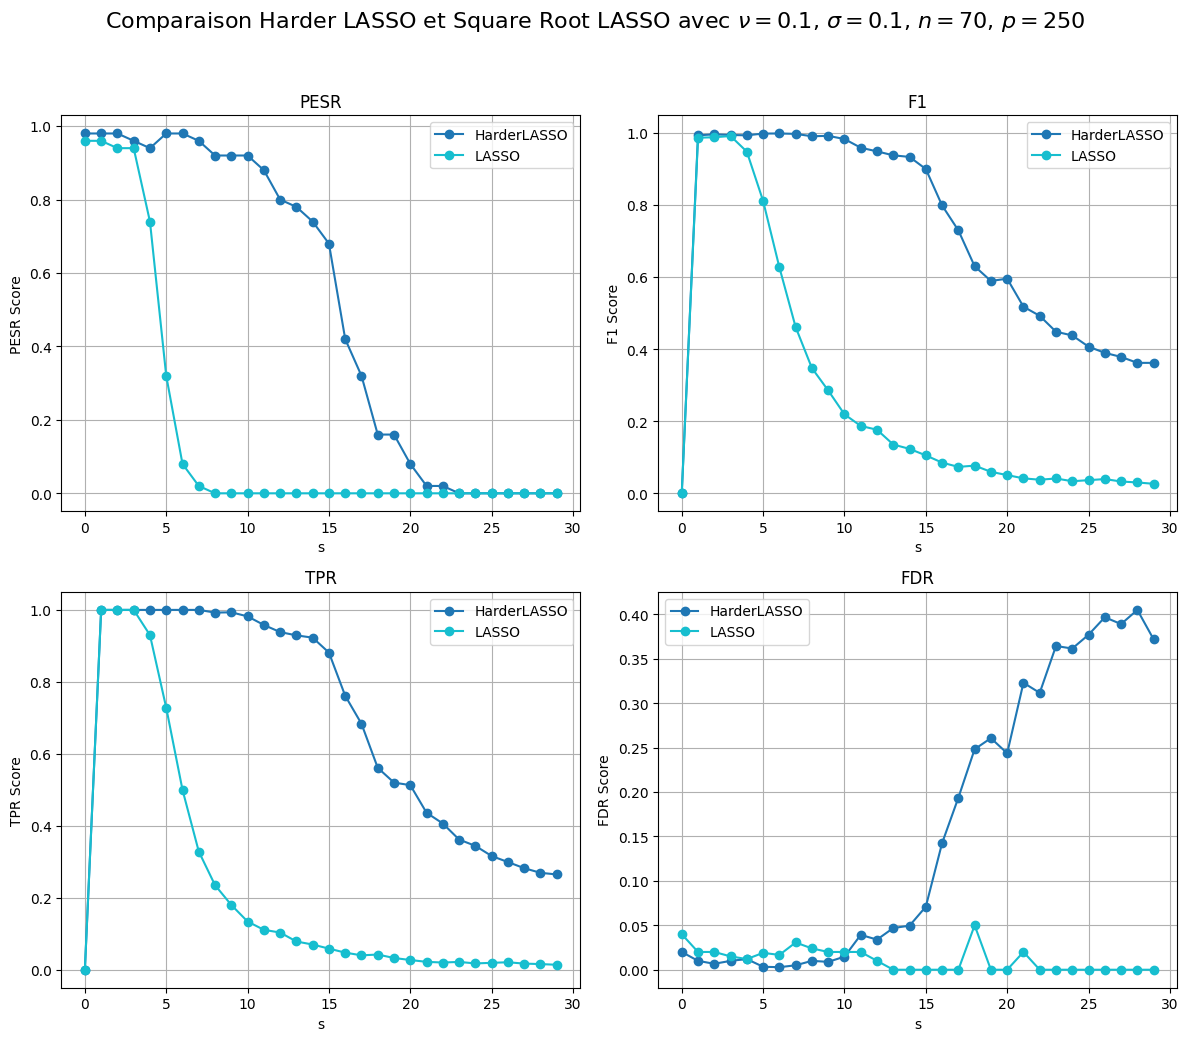

In [3]:
import numpy as np
from linear_tools import generate_data, pesr, tpr, fdr, f1, plot_scores, ista_backtracking, qut_square_root_lasso, dichotomie, newton, plot_simulations

class SimulationHarderLasso:

    def __init__(self, n, p, list_s, sigma, nu = None, simu_iter=100, qut_iter=100, max_iter=1000, tol=1e-6, seed=42, verbose=False):

        self.n = n
        self.p = p
        self.list_s = list_s
        self.sigma = sigma

        self.nu_vals = [nu] if nu is not None else [0.9, 0.9, 0.9, 0.9, 0.9, 0.9]

        self.L0 = 10
        self.beta0 = 3

        self.simu_iter = simu_iter
        self.qut_iter = qut_iter
        self.max_iter = max_iter

        self.tol = tol
        self.seed = seed
        np.random.seed(self.seed)
        np.set_printoptions(precision=3, suppress=True, linewidth=120)

        self.score = self._generate_score_empty()

        self.verbose = verbose

    def _generate_score_empty(self):
        return {
        'pesr': [],
        'f1': [],
        'tpr': [],
        'fdr': []
    }

    def _get_score(self, beta, beta_hat):
        return {
        'pesr': float(pesr(beta, beta_hat)),
        'f1': float(f1(beta, beta_hat)),
        'tpr': float(tpr(beta, beta_hat)),
        'fdr': float(fdr(beta, beta_hat))
    }

    def _generate_data(self, s, seed=False):
        if not seed: seed = self.seed
        y, X, beta = generate_data(n=self.n,
                            p=self.p, 
                            s=s,
                            sigma=self.sigma,
                            beta0=self.beta0,
                            seed=seed)
        X = X / X.std(axis=0)
        return y, X, beta

    def _get_lambda(self, X, alpha=0.05, seed=False):
        if not seed: seed = self.seed
        return qut_square_root_lasso(X=X,
                                M=self.qut_iter,
                                alpha=alpha,
                                seed=seed)
    
    def _get_lambda_nu_path(self, lmbda_max):
        path = []
        if len(self.nu_vals) == 1:
            return [(lmbda_max, self.nu_vals[0])]
        for k, nu_k in enumerate(self.nu_vals):
            ratio = np.exp(k) / (1 + np.exp(k))
            lmbda_k = ratio * lmbda_max
            path.append((lmbda_k, nu_k))
        return path
    
    def _f(self, beta, y, X):
        return np.linalg.norm(y - X @ beta, ord=2)
    
    def _g(self, beta, lmbda, nu):
        abs_beta = np.abs(beta)
        return lmbda * np.sum(abs_beta / (1 + abs_beta**(1 - nu)))

    def _grad_f(self, beta, y, X):
        r = y - X @ beta
        norm_r = np.linalg.norm(r, ord=2)
        if norm_r == 0:
            return np.zeros_like(beta)
        return -X.T @ r / norm_r

    def _get_jump(self, lmbda, nu):

        def F(k, lmbda, nu):
            return k**(2 - nu) + 2*k + k**nu + 2 * lmbda * (nu - 1)
        
        a, b = 1e-25, 500 
        return dichotomie(F, [lmbda, nu], a, b, self.tol)

    def _rho_nu_prime(self, beta, nu):
        abs_beta = np.abs(beta)
        denom = (1 + abs_beta**(1 - nu))**2
        return np.sign(beta) * (1 + nu * abs_beta**(1 - nu)) / denom

    def _drho_nu_prime(self, beta, nu):
        abs_beta = np.abs(beta)
        num = nu * (1 - nu) * abs_beta**(-nu)
        denom = (1 + abs_beta**(1 - nu))**3
        return num / denom

    def _F_beta(self, beta, z, lmbda, nu):
        return beta - z + lmbda * self._rho_nu_prime(beta, nu)

    def _F_beta_prime(self, beta, z, lmbda, nu):
        return 1 + lmbda * self._drho_nu_prime(beta, nu)

    def _prox_g(self, z, L, lmbda, nu):
        lmbda_scaled = lmbda / L

        if nu == 1.0:
            return np.sign(z) * np.maximum(np.abs(z) - lmbda_scaled, 0)

        kappa = self._get_jump(lmbda_scaled, nu)
        phi = 0.5 * kappa + lmbda_scaled / (1 + kappa**(1 - nu))

        prox = np.zeros_like(z)
        mask = np.abs(z) > phi
        
        prox[~mask] = 0.0

        for i in np.where(mask)[0]:
            prox[i] = newton(self._F_beta, self._F_beta_prime, F_args=(z[i], lmbda_scaled, nu), x0=z[i], tol=1e-6)
        return prox

    def _simulation(self, s):

        score = self._generate_score_empty()

        if self.verbose:
            print(f"|{s}| Simulations pour s = {s} :")

        for i in range(self.simu_iter):

            y, X, beta = self._generate_data(s, seed = self.seed + i)

            lmbda = 1 * self._get_lambda(X)

            beta_hat = np.zeros(self.p)
            path = self._get_lambda_nu_path(lmbda)

            for lmbda_k, nu_k in path:

                beta_hat = ista_backtracking(
                    f=self._f,
                    g=self._g,
                    grad_f=self._grad_f,
                    prox_g=self._prox_g,
                    x0=beta_hat,
                    L0=self.L0,
                    f_args=(y, X),
                    g_args=[lmbda_k, nu_k],
                    grad_f_args=(y, X),
                    prox_g_args=[lmbda_k, nu_k],
                    max_iter=self.max_iter,
                    tol=self.tol
                )

            score_tmp = self._get_score(beta, beta_hat)

            for key in score_tmp:
                score[key].append(score_tmp[key])

            if self.verbose:
                print(f"\t |{i+1}| Simulation {i+1}/{self.simu_iter} :")
                #print(f"\t\t beta : {beta}")
                #print(f"\t\t beta estimé : {beta_hat}")
                print(f"\t\t Lambda : {lmbda}")
                print(f"\t\t Score :")
                for key in score_tmp:
                    print(f"\t\t\t{key} : {score_tmp[key]}")

        score_m = self._generate_score_empty()

        for key in score_m:
            score_m[key].append(float(np.mean(score[key])))

        if self.verbose:
            print(f"\t Score :")
            for key in score_m:
                print(f"\t\t{key} : {score_m[key]}")

        return score_m

    def run(self):

        for s in self.list_s:

            score_tmp = self._simulation(s)

            for key in score_tmp:
                self.score[key].append(score_tmp[key])

    def plot(self):

        plot_scores(self.score, self.list_s, f"HARDER LASSO ISTA with backtracking σ={self.sigma}, n={self.n}, p={self.p}, nu={self.nu_vals[-1]}, warm start")

class SimulationSquareRootLasso:

    def __init__(self, n, p, list_s, sigma, simu_iter=100, qut_iter=100, max_iter=1000, tol=1e-6, seed=42, verbose=False):

        self.n = n
        self.p = p
        self.list_s = list_s
        self.sigma = sigma

        self.L0 = 10
        self.beta0 = 3 # Valeurs des coefficient non nulles pour les simulations

        self.simu_iter = simu_iter
        self.qut_iter = qut_iter
        self.max_iter = max_iter

        self.tol = tol
        self.seed = seed
        np.random.seed(self.seed)
        np.set_printoptions(precision=3, suppress=True, linewidth=120)

        self.score = self._generate_score_empty()

        self.verbose = verbose

    def _generate_score_empty(self):
        return {
        'pesr': [],
        'f1': [],
        'tpr': [],
        'fdr': []
    }

    def _get_score(self, beta, beta_hat):
        return {
        'pesr': float(pesr(beta, beta_hat)),
        'f1': float(f1(beta, beta_hat)),
        'tpr': float(tpr(beta, beta_hat)),
        'fdr': float(fdr(beta, beta_hat))
    }

    def _generate_data(self, s, seed=False):
        if not seed: seed = self.seed
        return generate_data(n=self.n,
                            p=self.p, 
                            s=s,
                            sigma=self.sigma,
                            beta0=self.beta0,
                            seed=seed)

    def _get_lambda(self, X, alpha=0.05, seed=False):
        if not seed: seed = self.seed
        return qut_square_root_lasso(X=X,
                                M=self.qut_iter,
                                alpha=alpha,
                                seed=seed)
    
    def _f(self, beta, y, X):
        return np.linalg.norm(y - X @ beta, ord=2)

    def _g(self, beta, lmbda):
        return lmbda * np.sum(np.linalg.norm(beta, ord=1))

    def _grad_f(self, beta, y, X):
        r = y - X @ beta
        norm_r = np.linalg.norm(r, ord=2)
        if norm_r == 0:
            return np.zeros_like(beta)
        return -X.T @ r / norm_r

    def _prox_g(self, z, L, lmbda):
        return  np.sign(z) * np.maximum(np.abs(z) - lmbda / L, 0)

    def _simulation(self, s):

        score = self._generate_score_empty()

        if self.verbose:
            print(f"|{s}| Simulations pour s = {s} :")

        for i in range(self.simu_iter):

            y, X, beta = self._generate_data(s, seed = self.seed + i)

            lmbda = self._get_lambda(X)

            beta_hat = np.zeros(self.p)

            beta_hat = ista_backtracking(f=self._f,
                            g=self._g,
                            grad_f=self._grad_f,
                            prox_g=self._prox_g,
                            x0=beta_hat,
                            L0=self.L0,
                            f_args=(y, X),
                            g_args=[lmbda],
                            grad_f_args=(y, X),
                            prox_g_args=[lmbda],
                            max_iter=self.max_iter,
                            tol=self.tol)

            score_tmp = self._get_score(beta, beta_hat)

            for key in score_tmp:
                score[key].append(score_tmp[key])

            if self.verbose:
                print(f"\t |{i+1}| Simulation {i+1}/{self.simu_iter} :")
                #print(f"\t\t beta : {beta}")
                #print(f"\t\t beta estimé : {beta_hat}")
                print(f"\t\t Lambda : {lmbda}")
                print(f"\t\t Score :")
                for key in score_tmp:
                    print(f"\t\t\t{key} : {score_tmp[key]}")

        score_m = self._generate_score_empty()

        for key in score_m:
            score_m[key].append(float(np.mean(score[key])))

        if self.verbose:
            print(f"\t Score :")
            for key in score_m:
                print(f"\t\t{key} : {score_m[key]}")

        return score_m

    def run(self):

        for s in self.list_s:

            score_tmp = self._simulation(s)

            for key in score_tmp:
                self.score[key].append(score_tmp[key])

    def plot(self):

        plot_scores(self.score, self.list_s, f"SQUARE ROOT LASSO ISTA with backtracking σ={self.sigma}, n={self.n}, p={self.p}")

n = 70
p = 250
list_s = range(0, 30)

sigma = 0.1
nu = 0.1

simu_iter=50
qut_iter=1000
max_iter=1000
tol=1e-6

seed=43

Sim1 = SimulationHarderLasso(
    n = n,
    p = p,
    list_s = list_s, 
    sigma = sigma,
    nu = nu,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol,
    seed = seed,
    verbose=False
)

Sim1.L0 = 0.1

Sim1.run()

Sim2 = SimulationSquareRootLasso(
    n = n,
    p = p,
    list_s = list_s,
    sigma = sigma,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol,
    seed = seed,
    verbose=False
)

Sim2.L0 = 1

Sim2.run()

simulations = {
    'HarderLASSO': Sim1.score,
    'LASSO': Sim2.score
}

plot_simulations(simulations, Sim1.list_s, fr"Comparaison Harder LASSO et Square Root LASSO avec $\nu={nu}$, $\sigma={sigma}$, $n={n}$, $p={p}$", save_path="G:/Mon Drive/Projets/Stage Genève/Rapport/images/graphs/comparaison_harder_lasso_square_root_lasso.pdf")